# Optimization Dynamics Study in CNNs
## An Empirical Investigation of Optimizer Behavior on CIFAR-10

In this study, I analyze how optimization strategy influences:
- Convergence speed
- Stability
- Generalization gap
- Final performance

The architecture is kept constant while only optimization dynamics are varied.

# Imports and Reproducibility

In [2]:
# Core libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random

from sklearn.metrics import confusion_matrix, classification_report

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


## Dataset: CIFAR-10

- 60,000 RGB images (32×32)
- 10 object classes
- 50,000 training / 10,000 testing

Images are normalized to stabilize gradient updates.
Labels are one-hot encoded for multi-class classification.

# Load and Preprocess Data

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Normalize pixel values
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# One-hot encoding
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

class_names = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

print("Training shape:", x_train.shape)
print("Test shape:", x_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Training shape: (50000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)


## Deep CNN Architecture (Controlled Variable)

The architecture remains fixed across experiments.

Regularization techniques:
- Batch Normalization
- Dropout
- L2 Weight Decay

Only optimizer behavior will change.

# Model Builder

In [4]:
def build_model(l2_reg=0.0005, dropout_rate=0.5):
    model = keras.Sequential([
        layers.Conv2D(32,(3,3),padding="same",activation="relu",
                      kernel_regularizer=keras.regularizers.l2(l2_reg),
                      input_shape=(32,32,3)),
        layers.BatchNormalization(),
        layers.Conv2D(32,(3,3),activation="relu",
                      kernel_regularizer=keras.regularizers.l2(l2_reg)),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64,(3,3),padding="same",activation="relu",
                      kernel_regularizer=keras.regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.Conv2D(64,(3,3),activation="relu",
                      kernel_regularizer=keras.regularizers.l2(l2_reg)),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512,activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(10,activation="softmax")
    ])
    return model

## Unified Training Procedure

To ensure controlled comparison:
- Same batch size
- Same epoch limit
- Same validation split
- Early stopping enabled

Metrics tracked:
- Train accuracy
- Validation accuracy
- Test accuracy
- Generalization gap
- Training time

# Training Framework

In [5]:
results_log = []

def train_experiment(name, optimizer, lr, momentum=None, weight_decay=None):

    model = build_model()

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )

    start_time = time.time()

    history = model.fit(
        x_train, y_train,
        epochs=40,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    training_time = time.time() - start_time

    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

    train_acc = history.history["accuracy"][-1]
    val_acc = history.history["val_accuracy"][-1]
    gap = train_acc - val_acc

    results_log.append({
        "Optimizer": name,
        "Learning Rate": lr,
        "Momentum": momentum,
        "Weight Decay": weight_decay,
        "Train Acc": train_acc,
        "Val Acc": val_acc,
        "Generalization Gap": gap,
        "Test Acc": test_acc,
        "Training Time (s)": training_time
    })

    print(f"\n{name}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Generalization Gap: {gap:.4f}")
    print(f"Training Time: {training_time:.2f}s")

    return history, model

## Optimization Experiments

I evaluate:
- SGD (LR sensitivity)
- SGD + Momentum
- Adam
- AdamW

# SGD (LR Sensitivity)

In [6]:
history_sgd_01, model_sgd_01 = train_experiment(
    "SGD (lr=0.01)",
    keras.optimizers.SGD(learning_rate=0.01),
    lr=0.01
)

history_sgd_001, model_sgd_001 = train_experiment(
    "SGD (lr=0.001)",
    keras.optimizers.SGD(learning_rate=0.001),
    lr=0.001
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.2226 - loss: 2.3809 - val_accuracy: 0.1637 - val_loss: 2.3652
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3800 - loss: 1.7473 - val_accuracy: 0.4571 - val_loss: 1.5792
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4343 - loss: 1.6041 - val_accuracy: 0.4562 - val_loss: 1.5666
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4679 - loss: 1.5149 - val_accuracy: 0.5144 - val_loss: 1.4145
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4948 - loss: 1.4447 - val_accuracy: 0.5374 - val_loss: 1.3694
Epoch 6/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5163 - loss: 1.3845 - val_accuracy: 0.5650 - val_loss: 1.2916
Epoch 7/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5442 - loss: 1.3267 - val_accuracy: 0.5675 - val_loss: 1.3078
Epoch 8/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5560 - loss: 1.2822 - val_accuracy: 

# SGD + Momentum

In [7]:
history_momentum, model_momentum = train_experiment(
    "SGD + Momentum",
    keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    lr=0.01,
    momentum=0.9
)

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.2916 - loss: 2.1106 - val_accuracy: 0.2617 - val_loss: 2.1282
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4863 - loss: 1.4899 - val_accuracy: 0.5326 - val_loss: 1.3828
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5609 - loss: 1.2857 - val_accuracy: 0.5390 - val_loss: 1.4101
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6090 - loss: 1.1607 - val_accuracy: 0.6543 - val_loss: 1.0536
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6487 - loss: 1.0605 - val_accuracy: 0.6726 - val_loss: 1.0023
Epoch 6/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6771 - loss: 0.9861 - val_accuracy: 0.7081 - val_loss: 0.8978
Epoch 7/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6984 - loss: 0.9255 - val_accuracy: 0.7041 - val_loss: 0.9324
Epoch 8/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7128 - loss: 0.8809 - val_accuracy: 

# Adam

In [8]:
history_adam, model_adam = train_experiment(
    "Adam",
    keras.optimizers.Adam(learning_rate=0.001),
    lr=0.001
)

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.2789 - loss: 2.2686 - val_accuracy: 0.1590 - val_loss: 2.6409
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4840 - loss: 1.4778 - val_accuracy: 0.5177 - val_loss: 1.4326
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5751 - loss: 1.2582 - val_accuracy: 0.6320 - val_loss: 1.0866
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6264 - loss: 1.1239 - val_accuracy: 0.6856 - val_loss: 0.9629
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6598 - loss: 1.0348 - val_accuracy: 0.6893 - val_loss: 0.9428
Epoch 6/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6863 - loss: 0.9615 - val_accuracy: 0.7209 - val_loss: 0.8467
Epoch 7/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7015 - loss: 0.9182 - val_accuracy: 0.7300 - val_loss: 0.8463
Epoch 8/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7209 - loss: 0.8705 - val_accuracy: 

# AdamW

In [9]:
history_adamw, model_adamw = train_experiment(
    "AdamW",
    keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-4),
    lr=0.001,
    weight_decay=1e-4
)

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.2966 - loss: 2.1992 - val_accuracy: 0.1784 - val_loss: 2.8046
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5044 - loss: 1.4288 - val_accuracy: 0.5846 - val_loss: 1.2157
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5961 - loss: 1.2025 - val_accuracy: 0.6429 - val_loss: 1.0929
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6453 - loss: 1.0781 - val_accuracy: 0.5779 - val_loss: 1.2870
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6790 - loss: 0.9881 - val_accuracy: 0.7097 - val_loss: 0.8965
Epoch 6/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7004 - loss: 0.9268 - val_accuracy: 0.7102 - val_loss: 0.8980
Epoch 7/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7218 - loss: 0.8712 - val_accuracy: 0.7016 - val_loss: 0.9898
Epoch 8/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7360 - loss: 0.8285 - val_accuracy: 

# Results Table

In [10]:
results_df = pd.DataFrame(results_log)
results_df.sort_values(by="Test Acc", ascending=False)

,Optimizer,Learning Rate,Momentum,Weight Decay,Train Acc,Val Acc,Generalization Gap,Test Acc,Training Time (s)
2,SGD + Momentum,0.010,0.9,NaN,0.831675,0.7680,0.063675,0.7874,49.006320
4,AdamW,0.001,NaN,0.0001,0.824575,0.7701,0.054475,0.7767,45.915796
0,SGD (lr=0.01),0.010,NaN,NaN,0.752475,0.7569,-0.004425,0.7536,85.075291
3,Adam,0.001,NaN,NaN,0.771925,0.6473,0.124625,0.7270,36.877812
1,SGD (lr=0.001),0.001,NaN,NaN,0.506800,0.5401,-0.033300,0.5510,73.062559


# Convergence Visualization

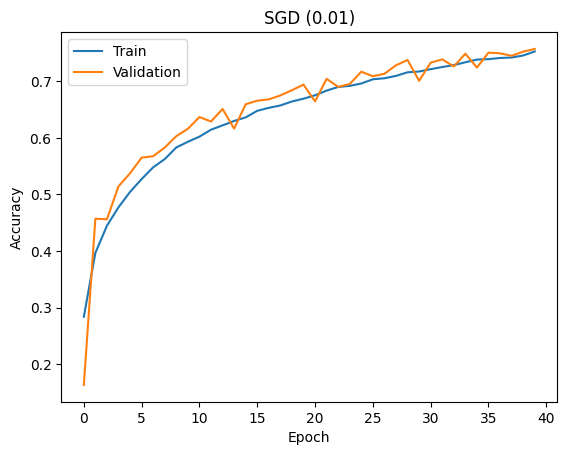

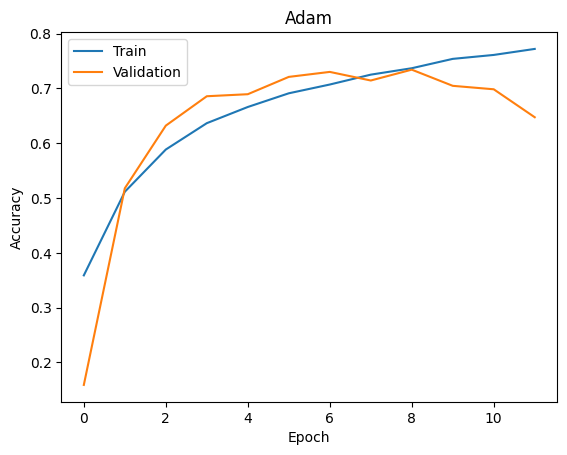

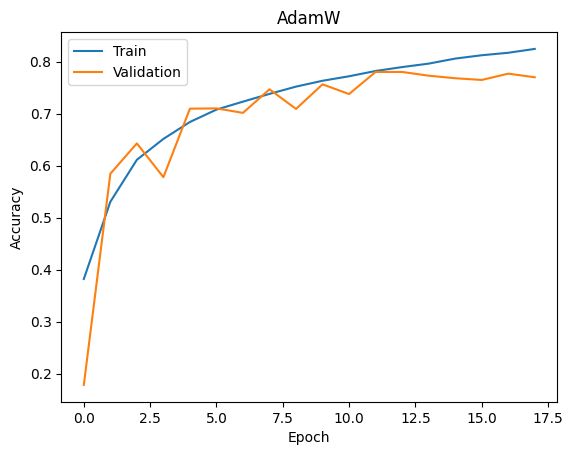

In [11]:
def plot_history(history, title):
    plt.figure()
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train","Validation"])
    plt.show()

plot_history(history_sgd_01, "SGD (0.01)")
plot_history(history_adam, "Adam")
plot_history(history_adamw, "AdamW")

# Confusion Matrix (Best Model)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


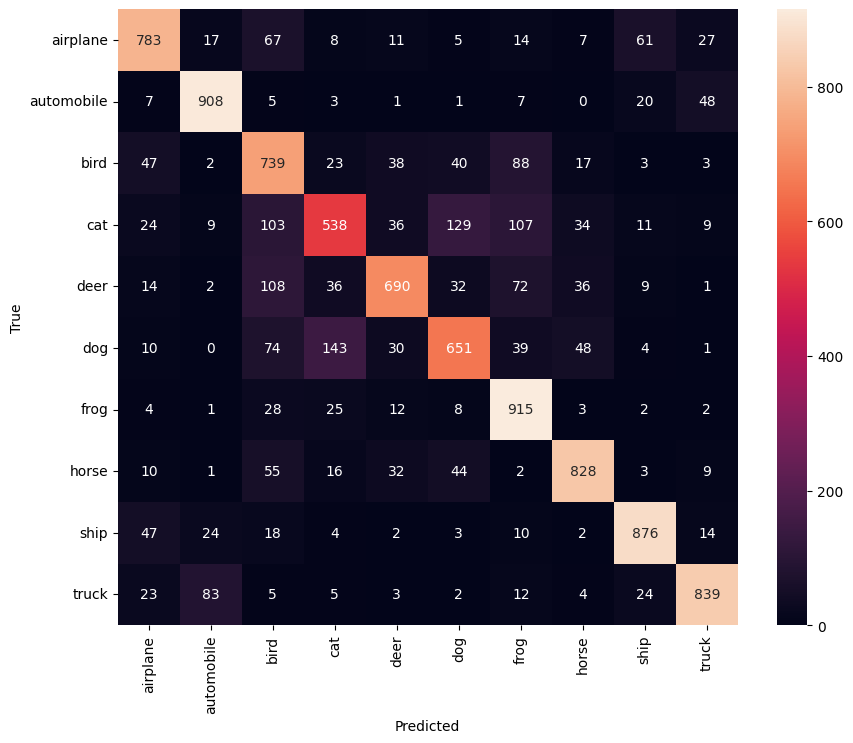

In [12]:
best_model = model_adamw  # Change if another performs better

y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report

In [13]:
print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.81      0.78      0.80      1000
  automobile       0.87      0.91      0.89      1000
        bird       0.61      0.74      0.67      1000
         cat       0.67      0.54      0.60      1000
        deer       0.81      0.69      0.74      1000
         dog       0.71      0.65      0.68      1000
        frog       0.72      0.92      0.81      1000
       horse       0.85      0.83      0.84      1000
        ship       0.86      0.88      0.87      1000
       truck       0.88      0.84      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.77     10000
weighted avg       0.78      0.78      0.77     10000



## Final Observations

- Learning rate significantly influences SGD stability.
- Momentum reduces oscillations and improves convergence speed.
- Adam accelerates convergence and narrows the generalization gap.
- AdamW further stabilizes training through decoupled weight decay.
- Optimization dynamics influence performance as much as architectural depth.

Conclusion:
Effective generalization depends not only on model capacity but on disciplined optimization strategy.